In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten


In [ ]:
image=cv2.imread('/content/drive/MyDrive/Plant dataset/PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_1.jpg')

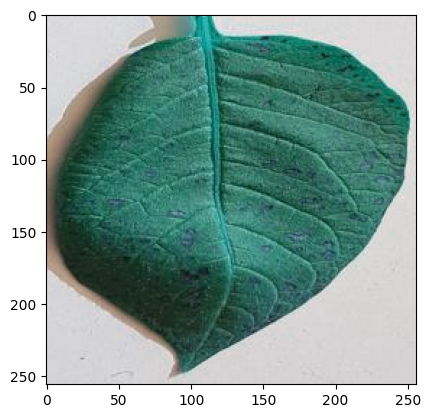

In [ ]:
plt.imshow(image)

In [ ]:
image.shape

(256, 256, 3)

In [ ]:
# Define the path to your dataset directories
train_dire = '/content/drive/MyDrive/Plant dataset/PLD_3_Classes_256/Training'
test_data_dir='/content/drive/MyDrive/Plant dataset/PLD_3_Classes_256/Testing'

In [ ]:
# Define a function for image preprocessing
def preprocess_image(image_path, target_size=(256, 256)):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load image '{image_path}'")
        return None

    # Convert the image to grayscale if it has multiple channels
    if len(img.shape) > 2 and img.shape[2] > 1:
        # print(img.shape)
        # img = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        img = cv2.resize(img, target_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        L,a,b=cv2.split(img)
        clahe=cv2.createCLAHE(2.0,(8,8))  # Convert to grayscale
        L = clahe.apply(L)  # Apply histogram equalization
        img=cv2.merge((L,a,b))
        img = img / 255.0  # Normalize pixel values to [0, 1]
        # img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img

Data augmentation code if dataset is very small.

In [ ]:
# def augment_data(X, y):
#     datagen = ImageDataGenerator(
#         rotation_range=40,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest'
#     )

#     augmented_data = []

#     for image, label in zip(X, y):
#         # Expand the dimensions to match the shape required by ImageDataGenerator
#         expanded_image = np.expand_dims(image, axis=0)

#         # Augment the image twice to create two augmented versions
#         for _ in range(2):
#             augmented_image = datagen.random_transform(expanded_image)
#             augmented_data.append((np.squeeze(augmented_image), label))  # Remove the added dimension

#     return augmented_data

In [ ]:
from sklearn.preprocessing import LabelEncoder

def load_dataset(data_dir):
    X = []
    y = []

    label_encoder = LabelEncoder()  # Initialize LabelEncoder

    # Collect all class labels
    class_labels = []

    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            class_labels.append(class_name)

    # Encode class labels to integers
    label_encoder.fit(class_labels)

    # Loop over classes again to load images and augment them
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            preprocessed_image = preprocess_image(image_path)



            X.append(preprocessed_image)  # Use 3D image
            y.append(class_name)  # Assuming the directory name is the class label

    # Augment the images and labels together


    # X_augmented = np.array(X)
    y = label_encoder.transform(y)

    return X, y


In [ ]:
X, y = load_dataset(train_dire)
X_test,y_test = load_dataset(test_data_dir)

(array([1303.,    0.,    0.,    0.,    0.,  816.,    0.,    0.,    0.,
        1132.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

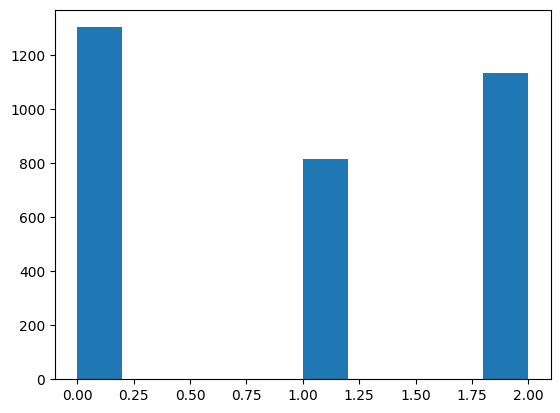

In [ ]:
plt.hist(y)

0 means Early Blight,
1 means Healthy,
2 means Late Blight.


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [ ]:
X[1].shape

(256, 256, 3)

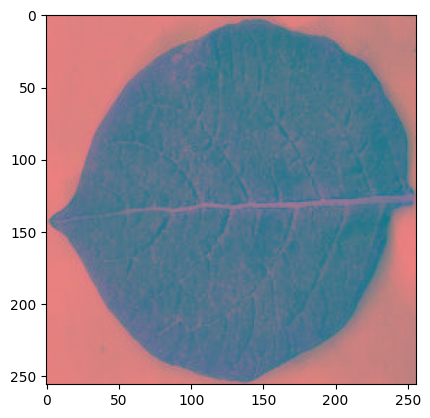

In [ ]:
plt.imshow(X[0])

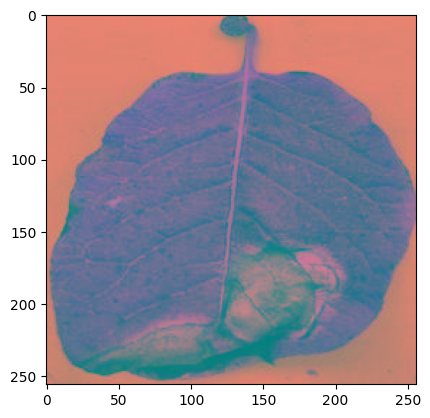

In [ ]:
plt.imshow(X[1303])

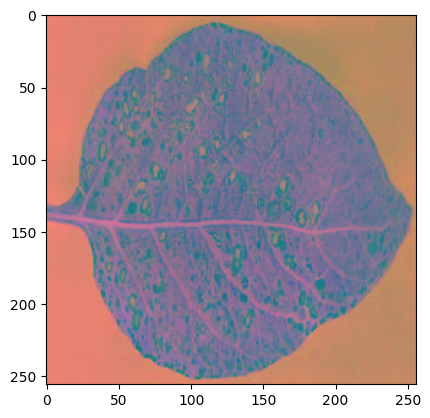

In [ ]:
plt.imshow(X[2119])

In [ ]:
unique_values = set(y)

# Count the number of unique values
num_unique_values = len(unique_values)
num_unique_values

3

In [ ]:
y[0]

1

In [ ]:
y[1303]

2

In [ ]:
y[2119]

0

In [ ]:
#Normalize the data
scaler=StandardScaler()
X_train=np.asarray(X_train)
X_test=np.asarray(X_test)
X_train = X_train.reshape(X_train.shape[0], -1)  # Reshape to 2D
# X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
# scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
# Train and evaluate Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)
print("\nDecision Tree Accuracy:", dt_accuracy)
dt_classification_report = classification_report(y_test, dt_predictions)
print("Decision Tree Classification Report:\n", dt_classification_report)


Decision Tree Accuracy: 0.6482334869431644
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.74      0.70       251
           1       0.68      0.63      0.65       172
           2       0.60      0.56      0.58       228

    accuracy                           0.65       651
   macro avg       0.65      0.64      0.64       651
weighted avg       0.65      0.65      0.65       651



In [ ]:
# Train and evaluate KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN Accuracy:", knn_accuracy)
knn_classification_report = classification_report(y_test, knn_predictions)
print("\nKNN Classification Report:\n", knn_classification_report)

KNN Accuracy: 0.620583717357911

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.90      0.72       251
           1       0.60      0.81      0.69       172
           2       0.87      0.17      0.29       228

    accuracy                           0.62       651
   macro avg       0.69      0.63      0.57       651
weighted avg       0.69      0.62      0.56       651



In [ ]:
# # Hyperparameter Tuning for SVM
# param_grid = {'C': [0.1, 1, 10, 100]}
# svm_model = SVC(kernel='rbf')
# grid_search = GridSearchCV(svm_model, param_grid, cv=5)
# grid_search.fit(X_train, y_train)
# best_C = grid_search.best_params_['C']

In [ ]:
# Train and evaluate SVM
svm_model = SVC(kernel='rbf',C=100)
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)
print("SVM Classification Report:")
svm_classification_report = classification_report(y_test, svm_predictions)
print("SVM Classification Report:\n", svm_classification_report)

SVM Accuracy: 0.8433179723502304
SVM Classification Report:
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87       251
           1       0.87      0.80      0.84       172
           2       0.83      0.80      0.82       228

    accuracy                           0.84       651
   macro avg       0.85      0.84      0.84       651
weighted avg       0.84      0.84      0.84       651

